Import Libraries

In [10]:
#Normal distribution functions
from scipy.stats import norm


# Load libraries
import numpy as np
import pandas as pd
import pandas_datareader.data as web
from matplotlib import pyplot
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.neural_network import MLPRegressor

#Libraries for Deep Learning Models
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.optimizers import SGD
from keras.layers import LSTM
from keras.wrappers.scikit_learn import KerasRegressor

#Libraries for Statistical Models
import statsmodels.api as sm

#Libraries for Saving the Model
from pickle import dump
from pickle import load

# Time series Models
from statsmodels.tsa.arima_model import ARIMA
#from statsmodels.tsa.statespace.sarimax import SARIMAX

# Error Metrics
from sklearn.metrics import mean_squared_error

# Feature Selection
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_regression


#Plotting 
from pandas.plotting import scatter_matrix
from statsmodels.graphics.tsaplots import plot_acf

#Diable the warnings
import warnings
warnings.filterwarnings('ignore')

Black Scholes Formula

In [11]:
true_alpha = 0.1
true_beta = 0.1
true_sigma0 = 0.2
interest = 0.05

def vol(moneyness, time):
    return true_sigma0 + true_alpha * time + true_beta * np.square(moneyness - 1)

def call_option_price(moneyness, time, option_vol):
    d1=(np.log(1/moneyness)+(interest + np.square(option_vol))*time)/(option_vol*np.sqrt(time))
    d2=(np.log(1/moneyness)+(interest - np.square(option_vol))*time)/(option_vol*np.sqrt(time))
    N_d1 = norm.cdf(d1)
    N_d2 = norm.cdf(d2)
    
    return N_d1 - moneyness * np.exp(- interest * time) * N_d2

Generating Data

In [16]:
N = 10000

moneys = 1+0.25*np.random.randn(N)
times = np.random.random(N)
volatility = np.array([vol(k,t) for k,t in zip(moneys, times)])
prices = np.array([call_option_price(k,t,sig) for k,t,sig in zip(moneys, times, volatility)])
print('moneys', moneys)
print('times', times)
print('volatility', volatility)
print('prices', prices)

moneys [0.76782109 0.87395608 1.10291291 ... 0.77338248 0.91823437 0.40281619]
times [0.35004584 0.42985217 0.92240233 ... 0.83474306 0.61971991 0.66576014]
volatility [0.24039529 0.24457392 0.29329934 ... 0.28860986 0.26264055 0.30223886]
prices [0.25351776 0.19414674 0.20112898 ... 0.31965555 0.21029677 0.6104165 ]


Visualize

[[0.76782109 0.35004584 0.24039529]
 [0.87395608 0.42985217 0.24457392]
 [1.10291291 0.92240233 0.29329934]
 ...
 [0.77338248 0.83474306 0.28860986]
 [0.91823437 0.61971991 0.26264055]
 [0.40281619 0.66576014 0.30223886]]

[0.25351776 0.19414674 0.20112898 ... 0.31965555 0.21029677 0.6104165 ]

      Price  Moneyness      Time  Volatility
0  0.253518   0.767821  0.350046    0.240395
1  0.194147   0.873956  0.429852    0.244574
2  0.201129   1.102913  0.922402    0.293299
3  0.108154   0.946589  0.200753    0.220361
4  0.016492   1.247997  0.282450    0.234395


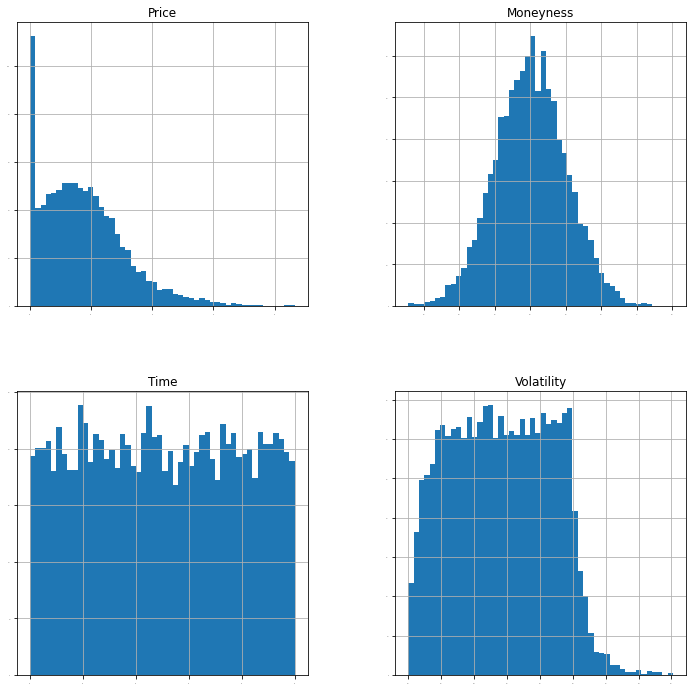

In [25]:
Y = prices
X = np.concatenate([moneys.reshape(-1,1), times.reshape(-1,1), volatility.reshape(-1,1)], axis=1)

dataset = pd.DataFrame(np.concatenate([Y.reshape(-1,1), X], axis=1),
                       columns=['Price', 'Moneyness', 'Time', 'Volatility'])
print(X)
print()
print(Y)
print()
print(dataset.head())
dataset.hist(bins=50, sharex=False, sharey=False, xlabelsize=1, ylabelsize=1, figsize=(12,12))
pyplot.show()

Train Test Split

In [26]:
#train-test = 80-20
validation_size = 0.2
train_size = int(len(X) * (1-validation_size))
print(train_size)
X_train, X_test = X[0:train_size], X[train_size:len(X)]
Y_train, Y_test = Y[0:train_size], Y[train_size:len(X)]

8000


Models

In [29]:
models = []

#Linear Models and Regression Trees
models.append(('LR', LinearRegression()))
models.append(('LASSO', Lasso()))
models.append(('EN', ElasticNet()))
models.append(('KNN', KNeighborsRegressor()))
models.append(('DT', DecisionTreeRegressor()))
models.append(('SVR', SVR()))

#Neural Network Predictor (Multi Layer Perceptron)
models.append(('MLP', MLPRegressor()))

# Boosting methods
models.append(('ABR', AdaBoostRegressor()))
models.append(('GBR', GradientBoostingRegressor()))
# Bagging methods
models.append(('RFR', RandomForestRegressor()))
models.append(('ETR', ExtraTreesRegressor()))

num_folds = 10
# scikit is moving away from mean_squared_error. 
# In order to avoid confusion, and to allow comparison with other models, we invert the final scores
scoring = 'neg_mean_squared_error' 
names = []
kfold_results = []
test_results = []
train_results = []
for name, model in models:
    names.append(name)
    
    ## K Fold analysis:
    
    kfold = KFold(n_splits=num_folds)
    
    #converted mean square error to positive. The lower the beter
    cv_results = -1* cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    kfold_results.append(cv_results)
    

    # Full Training period
    res = model.fit(X_train, Y_train)
    train_result = mean_squared_error(res.predict(X_train), Y_train)
    train_results.append(train_result)
    
    # Test results
    test_result = mean_squared_error(res.predict(X_test), Y_test)
    test_results.append(test_result)
    
    msg = "%s: %f (%f) %f %f" % (name, cv_results.mean(), cv_results.std(), train_result, test_result)
    print(msg)

LR: 0.000368 (0.000026) 0.000367 0.000325
LASSO: 0.018285 (0.001495) 0.018283 0.018369
EN: 0.018285 (0.001495) 0.018283 0.018369
KNN: 0.000016 (0.000008) 0.000008 0.000010
CART: 0.000011 (0.000001) 0.000000 0.000009
SVR: 0.004998 (0.000218) 0.005062 0.005084
MLP: 0.000031 (0.000014) 0.000021 0.000020
ABR: 0.000615 (0.000030) 0.000638 0.000653
GBR: 0.000020 (0.000001) 0.000016 0.000020
RFR: 0.000002 (0.000001) 0.000000 0.000002
ETR: 0.000001 (0.000000) 0.000000 0.000000


Results

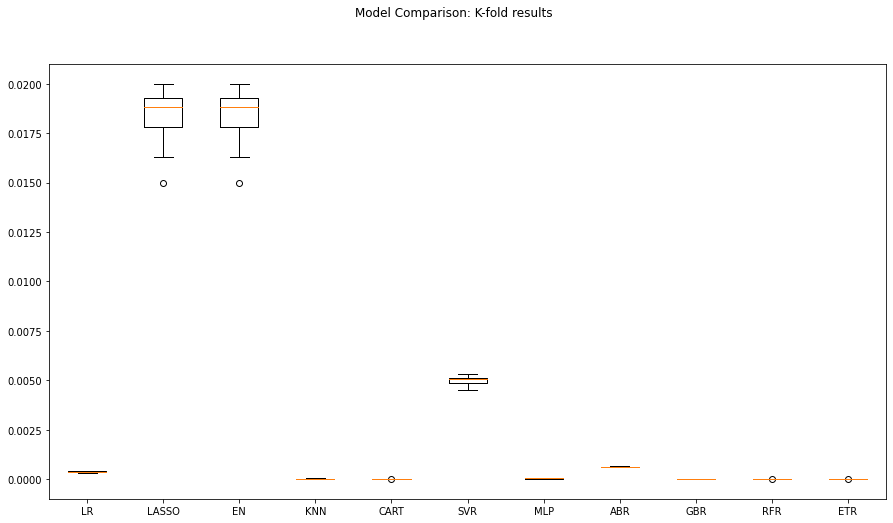

In [30]:
fig = pyplot.figure()
fig.suptitle('Model Comparison: K-fold results')
ax = fig.add_subplot(111)
pyplot.boxplot(kfold_results)
ax.set_xticklabels(names)
fig.set_size_inches(15,8)
pyplot.show()

Remove LASSO and ElasticNet

LR:   0.000367 0.000325
KNN:   0.000008 0.000010
CART:   0.000000 0.000009
SVR:   0.005062 0.005084
MLP:   0.000021 0.000020
ABR:   0.000638 0.000653
GBR:   0.000016 0.000020
RFR:   0.000000 0.000002
ETR:   0.000000 0.000000


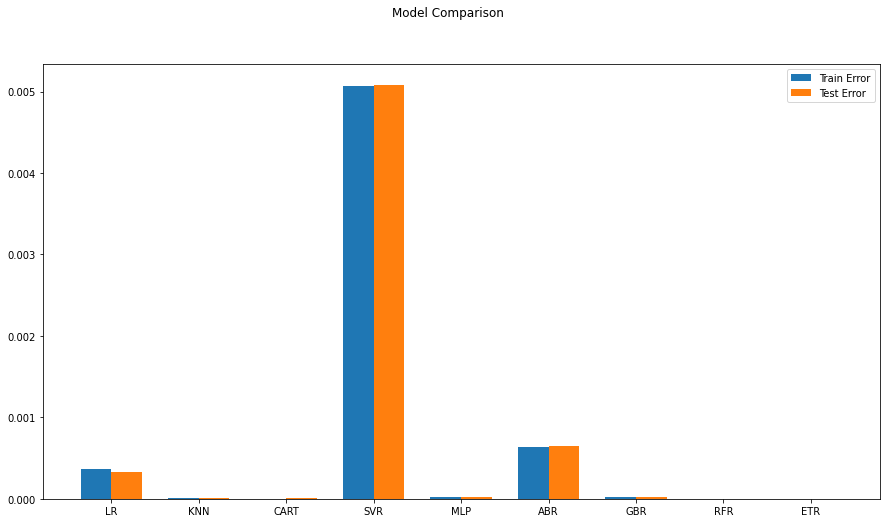

In [56]:
# compare algorithms
fig = pyplot.figure()
train = train_results[0:1] + train_results[3:]
test = test_results[0:1] + test_results[3:]
if 'LASSO' in names:
  names.remove('LASSO')
if 'EN' in names:
  names.remove('EN')

ind = np.arange(len(names))  # the x locations for the groups
width = 0.35  # the width of the bars
fig.suptitle('Model Comparison')
ax = fig.add_subplot(111)
pyplot.bar(ind - width/2, train,  width=width, label='Train Error')
pyplot.bar(ind + width/2, test, width=width, label='Test Error')
fig.set_size_inches(15,8)
pyplot.legend()
ax.set_xticks(ind)
ax.set_xticklabels(names)
for i in range(len(train)):
  p = "%s: %10f %f" % (names[i], train[i], test[i])
  print(p)
pyplot.show()